In [7]:
pip install git+https://github.com/Stanford-Health/wearipedia

  Cloning https://github.com/Stanford-Health/wearipedia to /private/var/folders/4q/pymtr0qd38d5nlrw_myxq5r00000gn/T/pip-req-build-tqsvx12y
  Running command git clone --filter=blob:none --quiet https://github.com/Stanford-Health/wearipedia /private/var/folders/4q/pymtr0qd38d5nlrw_myxq5r00000gn/T/pip-req-build-tqsvx12y
  Resolved https://github.com/Stanford-Health/wearipedia to commit bf7d7dccd940216d62284191c033f0cc8ea53aca
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Note: you may need to restart the kernel to use updated packages.


# Cronometer: Guide to data extraction and analysis

<img src='https://imgur.com/i6lFwtY.png' height="500"> 

A picture of the Cronometer Mobile Application



Do you know that DIET stands for Did I Eat That? <br> <br>
Jokes aside, in this notebook we will be doing just that. We will connect to the Cronometer API to analyze the participants nutritional and exercise habits.

Cronometer is often regarded as the “[best nutrition app for Android and iOS](https://www.makeuseof.com/cronometer-health-app-android-ios/).” It lets you track your meals, count calories, identify gaps in your diet, and check your health metrics. It is also compatible with popular fitness devices like Fitbit, Strava, Withings, Garmin, Polar, Qardio and Oura. <br>

Cronometer follows a fremium model offering a digital service accessible through its mobile applications (iOS and Android). Users also have an option to upgrade and unlock more advanced features like Custom Goals, Training Plans, Race Analysis, etc for a monthly fee of $8.99. <br>

We've been using the cronometer application for the past few weeks and we will show you how to extract its data, visualize the participants data and compute correlations between multiple metrics. Cronometer does not have a public API, so we would reversed engineered the cornometer api within wearipedia in order to extract servings, daily-nutrition, exercises, notes, and biometrics. <br>



We will be able to extract the following parameters:

Parameter Name  | Sampling Frequency 
-------------------|-----------------
<b>Body Measurements</b> |  Per Entry 
Blood Pressure |   Per Entry / Day 
<b>Heart Rate</b> |  Per Entry / Day
Oxygen Saturation |  Per Entry / Day 
VO2 Max |  Per Entry / Day
Pulse Wave Velocity |  Per Entry / Day
Labs/ Test Results |  Per Entry / Day
Mood |  Per Entry / Day
Sleep |  Per Entry / Day
<b>Food Nutrition Breakdown</b> |  Per Serving
<b>Exercise Minutes</b>  |  Per Exercise Entry
<b>Exercise Calories Burned</b>  |  Per Exercise Entry
<b>Daily Nutrition Breakdown</b> |  Per Day

In this guide, we sequentially cover the following **nine** topics to extract data from Cronometer servers:

1. **Setup**<br>
2. **Authentication and Authorization**<br>
   - Requires only username and password, no OAuth.<br>
3. **Data Extraction**<br>
  - We get data via wearipedia in a couple lines of code<br>
4. **Data Exporting**
    - We export all of this data to file formats compatible by R, Excel, and MatLab.
5. **Adherence**
    - We simulate non-adherence by dynamically removing datapoints from our simulated data.
6. **Visualization**
    - We create a simple plot to visualize our data.
7. **Advanced visualization**
    - 7.1 Plotting the participants weight! <br>
    - 7.2 Plotting participants Workout Minutes! <br>
    - 7.3 Calorie Consumption Breakdown! <br>
8. **Data Analysis** <br>
  - 8.1  Analyzing correlation between Protein Content and Vitamin B content in food items! <br>
9. **Outlier Detection** <br>
  - 9.1 Highlighting Outliers!

Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own email and password on your own Colab instance, you can visualize your own *real* data. That being said, we were unable to thoroughly test the timezone functionality, though, since we only have one account, so beware.

# 1. Setup

## Participant Setup

Dear Participant,

Once you download the cronometer app, please set it up by following these resources:
- Written guide: https://support.cronometer.com/hc/en-us/articles/360021677792-Mobile-Quick-Start-Guide
- Video guide: https://www.youtube.com/watch?v=XyeXp_wo0to&ab_channel=Cronometer

Make sure that your phone is logged to the cronometer app using the Cronometer login credentials (email and password) given to you by the data receiver.

Best,

Wearipedia

## Data Receiver Setup

Please follow the below steps:

1. Create an email address for the participant, for example `foo@email.com`.
2. Create a Cronometer account with the email `foo@email.com` and some random password.
3. Keep `foo@email.com` and password stored somewhere safe.
4. Request the participant to download the app and instruct them to follow the participant setup letter above.
5. Install the `wearipedia` Python package to easily extract data from this app via the Cronometer API.


In [8]:
# !pip install wearipedia
!pip install openpyxl
!pip uninstall -y seaborn
!pip install seaborn==0.11.1

Found existing installation: seaborn 0.11.1
Uninstalling seaborn-0.11.1:
  Successfully uninstalled seaborn-0.11.1
  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)


In [9]:
import os
import pandas as pd
import wearipedia
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from sklearn.covariance import EllipticEnvelope
import copy
import seaborn as sns
from matplotlib import font_manager as fm
from matplotlib import lines as mlines
from scipy.ndimage import gaussian_filter
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import json



# 2. Authentication and Authorization

To obtain access to data, authorization is required. All you'll need to do here is just put in your email and password for your Cronometer account. We'll use this username and password to extract the data in the sections below.

In [10]:
#@title Enter Cronometer login credentials
email_address = "xxxxxxx@gmail.com" #@param {type:"string"}
password = "........#" #@param {type:"string"}

# 3. Data Extraction

Data can be extracted via [wearipedia](https://github.com/Stanford-Health/wearipedia/), our open-source Python package that unifies dozens of complex wearable device APIs into one simple, common interface.

First, we'll set a date range and then extract all of the data within that date range. You can select whether you would like synthetic data or not with the checkbox.

In [11]:
#@title Enter start and end dates (in the format yyyy-mm-dd)

#set start and end dates - this will give you all the data from 2000-01-01 (January 1st, 2000) to 2100-02-03 (February 3rd, 2100), for example
start_date='2022-03-01' #@param {type:"string"}
end_date='2022-09-17' #@param {type:"string"}
synthetic = True #@param {type:"boolean"}

In [12]:
device = wearipedia.get_device("cronometer/cronometer")

if not synthetic:
    device.authenticate({"username": email_address, "password": password})

params = {"start_date": start_date, "end_date": end_date}

We will first extract the daily summary of energy (calories) consumed in a day, as well as the consumption of different nutrients per day, such as vitamins, minerals, proteins, and carbohydrates.

In [13]:
dailySummary = device.get_data("dailySummary", params=params)
pd.DataFrame(dailySummary).head()

,Day,Energy (kcal),Alcohol (g),Caffeine (mg),Water (g),B1 (Thiamine) (mg),B2 (Riboflavin) (mg),B3 (Niacin) (mg),B5 (Pantothenic Acid) (mg),B6 (Pyridoxine) (mg),...,Leucine (g),Lysine (g),Phenylalanine (g),Protein (g),Threonine (g),Tryptophan (g),Tyrosine (g),Valine (g),Methionine (g),Completed
0,2022-03-01,2895.26,0.60,333.38,3682.55,1.18,1.28,13.90,3.58,1.61,...,2.46,75.11,53.44,57.02,35.37,22.70,509.31,42.32,501.49,True
1,2022-03-02,3229.87,4.11,69.99,1132.89,1.29,1.30,16.18,4.41,1.69,...,2.59,82.46,54.52,2.86,38.67,15.91,522.66,46.50,498.23,True
2,2022-03-03,2524.79,5.80,393.77,3425.90,1.19,1.23,15.96,6.05,1.69,...,2.53,70.45,47.17,331.40,49.00,12.11,522.87,49.06,501.25,False
3,2022-03-04,1554.14,7.31,383.48,1039.07,1.19,1.25,14.49,5.62,1.70,...,2.49,82.50,52.42,115.05,46.91,15.67,479.65,45.05,501.52,False
4,2022-03-05,1797.66,1.32,353.96,3836.29,1.28,1.35,19.67,4.51,1.66,...,2.47,79.49,56.68,176.53,37.50,24.47,494.98,42.41,500.25,False


We will first extract the nutrient summary of energy (calories) consumed per meal serving, as well as the consumption of different nutrients per day, such as vitamins, minerals, proteins, and carbohydrates.

In [14]:
servings = device.get_data("servings", params=params)
pd.DataFrame(servings).head()

,Day,Food Name,Amount,Energy (kcal),Alcohol (g),Caffeine (mg),Water (g),B1 (Thiamine) (mg),B2 (Riboflavin) (mg),B3 (Niacin) (mg),...,Leucine (g),Lysine (g),Methionine (g),Phenylalanine (g),Protein (g),Threonine (g),Tryptophan (g),Tyrosine (g),Valine (g),Category
0,2022-03-01,"Chipotle, Black Beans","1.00 cup, whole pieces",196.16,0.0,0.0,122.04,0.34,0.09,0.79,...,0.94,0.81,0.18,0.64,11.95,0.50,0.14,0.34,0.62,Fast Foods
1,2022-03-02,"Yam, Cooked, Boiled, Drained, or Baked, with Salt",300.00 g,342.00,NaN,NaN,210.39,0.28,0.08,1.66,...,0.28,0.17,0.06,0.21,4.47,0.16,0.04,0.12,0.18,Vegetables and Vegetable Products
2,2022-03-03,"Lasagna, Homemade, Beef",100.00 g,160.89,0.0,0.0,81.24,0.21,0.17,1.42,...,0.89,0.74,0.23,0.48,10.55,0.45,0.15,0.41,0.56,"Meals, Entrees, and Sidedishes"
3,2022-03-04,"Sausage, Pork, Fresh",3.00 medium link - breakfast size,195.00,0.0,0.0,29.93,0.15,0.11,3.67,...,0.82,0.74,0.26,0.40,11.12,0.37,0.11,0.31,0.53,Sausages and Luncheon Meats
4,2022-03-05,"Whole Wheat Bread, Store Bought",2.00 medium slice,181.44,0.0,0.0,28.09,0.28,0.12,3.20,...,0.29,0.12,0.07,0.20,8.96,0.12,0.07,0.13,0.20,Baked Products


Next, we will extract data on exercises recorded in cronomterer with their duration and calories burned.

In [15]:
exercises = device.get_data("exercises", params=params)
pd.DataFrame(exercises).head()

,Day,Exercise,Minutes,Calories Burned
0,2022-03-01,Volleyball,66.165803,-330.829013
1,2022-03-01,Active Energy Balance (Apple Health),62.692991,-313.464955
2,2022-03-02,Basketball,56.827523,-284.137614
3,2022-03-02,Active Energy Balance (Apple Health),80.784520,-403.922602
4,2022-03-03,Handball,57.367786,-229.471145


Lastly, we will be extracting biometric data like weight, heartrate, v02 max, etc that has been recorded with cronometer.

In [16]:
biometrics = device.get_data("biometrics", params=params)
pd.DataFrame(biometrics)

,Day,Metric,Unit,Amount
0,2022-03-01,Weight,kg,94.371378
1,2022-03-01,Heart Rate (Apple Health),bpm,100.000000
2,2022-03-02,Weight,kg,95.566218
3,2022-03-02,Heart Rate (Apple Health),bpm,129.000000
4,2022-03-03,Weight,kg,92.742544
...,...,...,...,...
395,2022-09-14,Heart Rate (Apple Health),bpm,100.000000
396,2022-09-15,Weight,kg,94.039550
397,2022-09-15,Heart Rate (Apple Health),bpm,123.000000
398,2022-09-16,Weight,kg,93.411710


# 4. Data Exporting

In this section, we export all of this data to formats compatible with popular scientific computing software (R, Excel, Google Sheets, Matlab). Specifically, we will first export to JSON, which can be read by R and Matlab. Then, we will export to CSV, which can be consumed by Excel, Google Sheets, and every other popular programming language.

## Exporting to JSON (R, Matlab, etc.)

Exporting to JSON is fairly simple. We export each datatype separately and also export a complete version that includes all simultaneously.

In [17]:
json.dump(dailySummary, open("dailySummary.json", "w"))
json.dump(servings, open("servings.json", "w"))
json.dump(exercises, open("exercises.json", "w"))
json.dump(biometrics, open("biometrics.json", "w"))

complete = {
    "dailySummary": dailySummary,
    "servings": servings,
    "exercises": exercises,
    "biometrics": biometrics
}

json.dump(complete, open("complete.json", "w"))

Feel free to open the file viewer (see left pane) to look at the outputs!

## Exporting to CSV and XLSX (Excel, Google Sheets, R, Matlab, etc.)

Exporting to CSV/XLSX requires a bit more processing, since they enforce a pretty restrictive schema.

We will thus export steps, heart rates, and breath rates all as separate files.

In [18]:

dailySummary_df = pd.DataFrame.from_dict(dailySummary)

dailySummary_df.to_csv('dailySummary.csv')
dailySummary_df.to_excel('dailySummary.xlsx')

servings_df = pd.DataFrame.from_dict(servings)

servings_df.to_csv('servings.csv', index=False)
servings_df.to_excel('servings.xlsx', index=False)

exercises_df = pd.DataFrame.from_dict(exercises)

exercises_df.to_csv('exercises.csv', index=False)
exercises_df.to_excel('exercises.xlsx', index=False)

biometrics_df = pd.DataFrame.from_dict(biometrics)

biometrics_df.to_csv('biometrics.csv', index=False)
biometrics_df.to_excel('biometrics.xlsx', index=False)

Again, feel free to look at the output files and download them.

# 5. Adherence

The device simulator already automatically randomly deletes small chunks of the day. In this section, we will simulate non-adherence over longer periods of time from the participant (day-level and week-level).

Then, we will detect this non-adherence and give a Pandas DataFrame that concisely describes when the participant has had their device on and off throughout the entirety of the time period, allowing you to calculate how long they've had it on/off etc.

We will first delete a certain % of blocks either at the day level or week level, with user input.

In [19]:
#@title Non-adherence simulation
block_level = "day" #@param ["day", "week"]
adherence_percent = 0.89 #@param {type:"slider", min:0, max:1, step:0.01}

In [20]:
if block_level == "day":
    block_length = 1
elif block_level == "week":
    block_length = 7

# This function will randomly remove datapoints from the 
# data we have recieved from Cronometer based on the
# adherence_percent

def AdherenceSimulator(data):
  num_blocks = len(data) // block_length
  num_blocks_to_keep = int(adherence_percent * num_blocks)
  idxes = np.random.choice(np.arange(num_blocks), replace=False, 
  size=num_blocks_to_keep)
  adhered_data = []
  for i in range(len(data)):
      if i in idxes:
          start = i * block_length
          end = (i + 1) * block_length
          for j in range(i,i+1):
            adhered_data.append(data[j])
  return adhered_data

# Adding adherence for daily summary

dailySummary = AdherenceSimulator(dailySummary)

# Adding adherence for exercises

exercises = AdherenceSimulator(exercises)

# Adding adherence for biometrics

biometrics = AdherenceSimulator(biometrics)

# Adding adherence for servings

servings = AdherenceSimulator(servings)

And now we have significantly fewer datapoints! This will give us a more realistic situation, where participants may take off their device for days or weeks at a time.

Now let's detect non-adherence. We will return a Pandas DataFrame sampled at every day.

In [21]:
dailySummary_df = pd.DataFrame.from_dict(dailySummary)
servings_df = pd.DataFrame.from_dict(servings)
exercises_df = pd.DataFrame.from_dict(exercises)
biometrics_df = pd.DataFrame.from_dict(biometrics)

We can plot this out, and we get adherence at one-day frequency throughout the entirety of the data collection period. For this chart we will plot Energy consumed over the time period from the dailySummary dataframe.

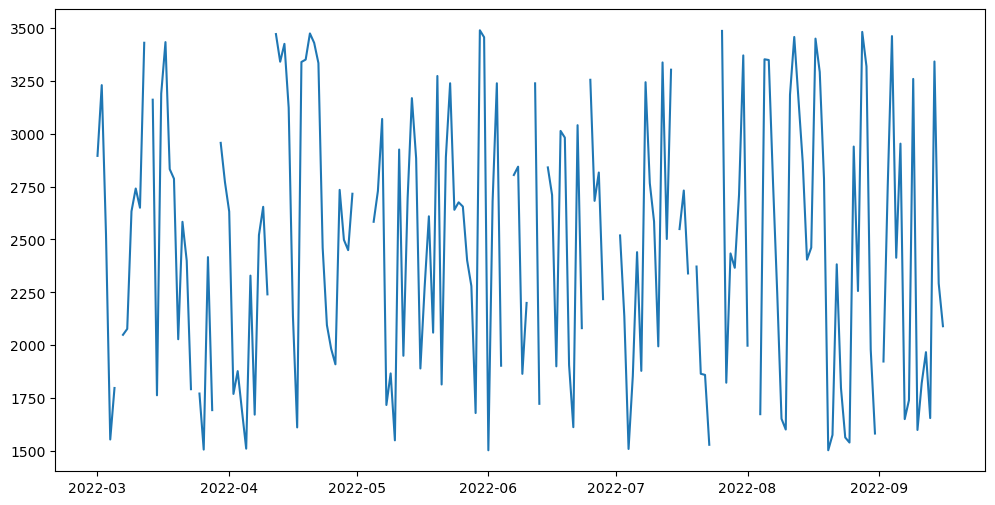

In [25]:
dates = pd.date_range(start_date,end_date)

energy = []

for d in dates:
  res = dailySummary_df[dailySummary_df.Day == datetime.strftime(d,
  '%Y-%m-%d')]['Energy (kcal)']
  if len(res) == 0:
    energy.append(None)
  else:
    energy.append(res.iloc[0])

plt.figure(figsize=(12, 6))
plt.plot(dates, energy)
plt.show()

# 6. Visualization

We've extracted lots of data, but what does it look like?

In this section, we will be visualizing our three kinds of data in a simple, customizable plot! This plot is intended to provide a starter example for plotting, whereas later examples emphasize deep control and aesthetics.

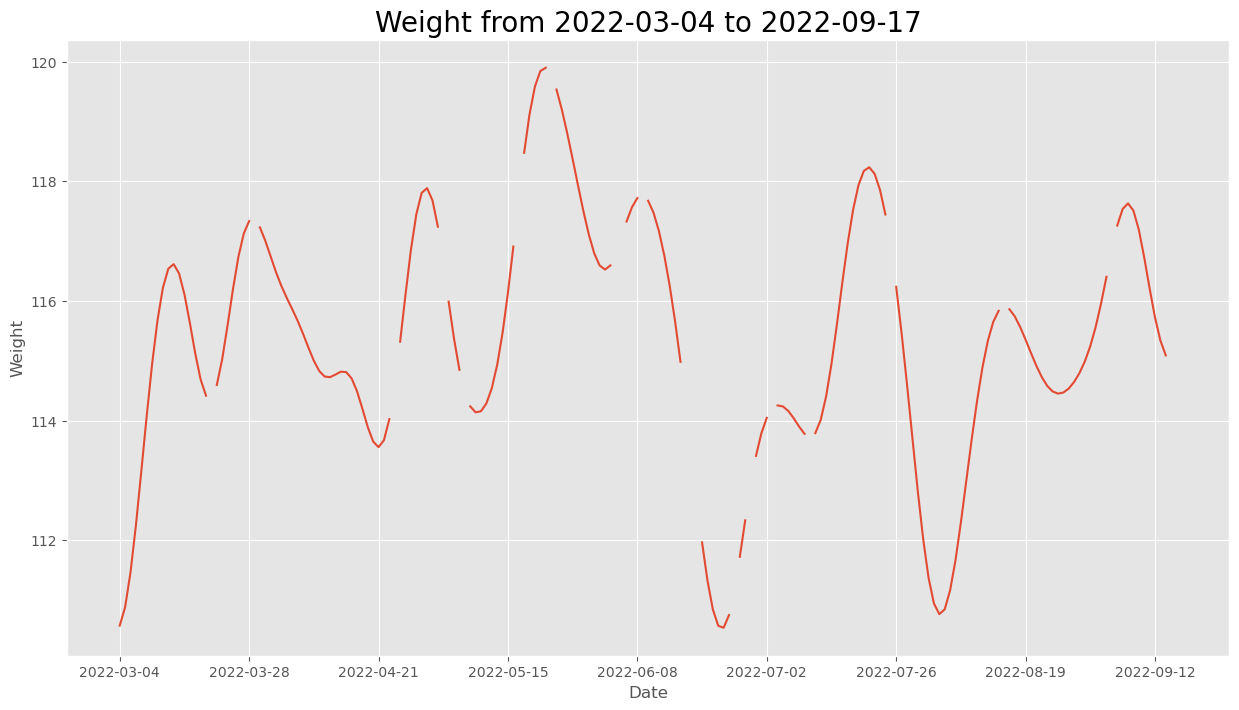

In [26]:
#@title Basic Plot
feature = "Heart Rate (Apple Health)" #@param ['Heart Rate (Apple Health)', 'Weight']
start_date = "2022-03-04" #@param {type:"date"}
time_interval = "full time" #@param ["one week", "full time"]
smoothness = 0.02 #@param {type:"slider", min:0, max:1, step:0.01}
smooth_plot = True #@param {type:"boolean"}

start_date = datetime.strptime(start_date, '%Y-%m-%d')

if time_interval == "one week":
    day_idxes = [i for i,d in enumerate(dates) if d >= start_date and d <= start_date + timedelta(days=7)]
    end_date = start_date + timedelta(days=7)
elif time_interval == "full time":
    day_idxes = [i for i,d in enumerate(dates) if d >= start_date]
    end_date = dates[-1]

if feature == "Weight":
    weights = biometrics_df[biometrics_df['Metric']=='Weight']
    concat_weight = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')
        if i in day_idxes:
          weight = weights[weights['Day']==day]
          if len(weight) != 0:
              concat_weight += [(day,weight.iloc[0].Amount)]
          else:
              concat_weight += [(day,None)]
    ts = [x[0] for x in concat_weight]

    day_arr = [x[1] for x in concat_weight]

    sigma = 200 * smoothness

    title_fillin = "Weight"

  
if feature == 'Heart Rate (Apple Health)':
    hrs = biometrics_df[biometrics_df['Metric']=='Heart Rate (Apple Health)']
    concat_hr = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')
        if i in day_idxes:
          hr = hrs[hrs['Day']==day]
          if len(hr) != 0:
              concat_hr += [(day,hr.iloc[0].Amount)]
          else:
              concat_hr += [(day,None)]
    ts = [x[0] for x in concat_hr]

    day_arr = [x[1] for x in concat_hr]

    sigma = 200 * smoothness

    title_fillin = "Weight"


with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(15, 8))

    if smooth_plot:
        def to_numpy(day_arr):
            arr_nonone = [x for x in day_arr if x is not None]
            mean_val = int(np.mean(arr_nonone))
            for i,x in enumerate(day_arr):
                if x is None:
                    day_arr[i] = mean_val

            return np.array(day_arr)

        none_idxes = [i for i,x in enumerate(day_arr) if x is None]
        day_arr = to_numpy(day_arr)
        day_arr = list(gaussian_filter(day_arr, sigma=sigma))
        for i, x in enumerate(day_arr):
            if i in none_idxes:
                day_arr[i] = None

    plt.plot(ts, day_arr)
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')
    plt.title(f"{title_fillin} from {start_date_str} to {end_date_str}",
              fontsize=20)
    plt.xlabel("Date")
    plt.xticks(ts[::int(len(ts)/8)])
    plt.ylabel(title_fillin)

This plot allows you to quickly scan your data at many different time scales (week and full) and for different kinds of measurements (heart rate and weight), which enables easy and fast data exploration.

Furthermore, the smoothness parameter makes it easy to look for patterns in long-term trends.

# 7. Advanced Visualization

Now we'll do some more advanced plotting that at times features hardcore matplotlib hacking with the benefit of aesthetic quality.

## 7.1 Calorie Consumption Breakdown

Cronometer App is particularly known for its meal tracking features. If a user went onto their Trends, they will be able to see a day-wise calorie breakdown like the one shown below.

<img src="https://i.imgur.com/Dl2V9wl.jpg" width='500px'>

*Above is a plot from the mobile app itself!*

This is a detailed breakdown which shows a user how many kilocalories they are consuming in Proteins, Carbohydrates, Fats and Alcohols. <br><br>

The Cronometer API also gave us access to the participants daily nutrition data. This would enable us to exactly re-create this chart using Python.

In [27]:
#@title Enter the Start Date

year_string = '2022' #@param {type:"string"}
month_string = '07' #@param {type:"string"}
day_string = '20' #@param{type:"string"}

start_date = year_string+'-'+month_string+'-'+day_string


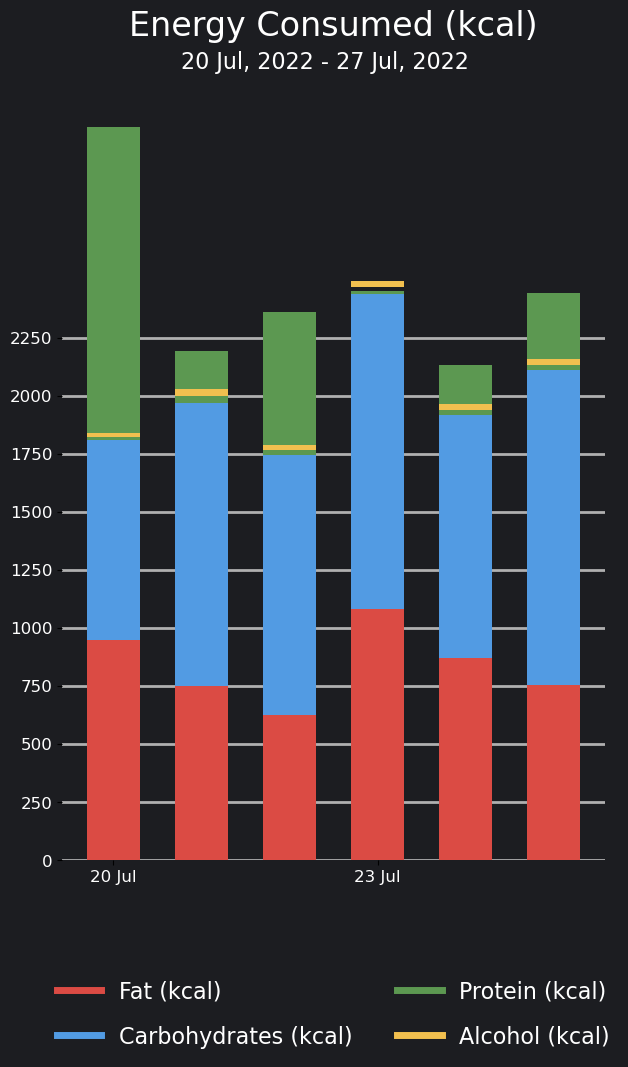

In [36]:

#@title Enter the End Date and plotting

year_string = '2022' #@param {type:"string"}
month_string = '07' #@param {type:"string"}
day_string = '27' #@param{type:"string"}

end_date = year_string+'-'+month_string+'-'+day_string

nutrition = dailySummary_df
test = nutrition[nutrition.get('Day')>=start_date].get(['Day','Carbs (g)','Fat (g)','Protein (g)','Alcohol (g)','Energy (kcal)'])
test = test[test.get('Day')<=end_date]

def date_fixer(date):
  # Creating a date time object for the date
  date = datetime.strptime(date,'%Y-%m-%d')
  # Returning the date in the required format
  return str(date.strftime("%B"))[:3]+' '+str(date.day)

# Fixing the Date Values for the xticks in our chart
test = test.assign(Date_formatted = test.get('Day').apply(lambda x: 
                        date_fixer(x).split()[1]+' '+date_fixer(x).split()[0]))

# 1g Carbs is equal to 4 kcal
test = test.assign(Carbs = test.get('Carbs (g)')*4)

# 1g Proteins is equal to 4 kcal
test = test.assign(Protein = test.get('Protein (g)')*4)

# 1g Fats is equal to 9 kcal
test = test.assign(Fat = test.get('Fat (g)')*9)

# 1g Alcohol is equal to 7 kcal
test = test.assign(Alcohol = test.get('Alcohol (g)')*7)

# Creating a matplotlib plot of size 16,8 
fig3 = plt.figure(figsize=(7,10),facecolor='#1C1D21')
ax = fig3.gca()
ax.set_facecolor('#1C1D21')
ax.set_axisbelow(True)

# Remove the outline and set background color
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_facecolor('none')  # Set the axes background color


# Adding header to the chart
header_text = (test.iloc[0].get('Date_formatted')+', '+
              test.iloc[-1].get('Day').split('-')[0]+' - '+
              test.iloc[-1].get('Date_formatted')+', '+
              test.iloc[0].get('Day').split('-')[0])
plt.title('Energy Consumed (kcal)',y=1.06, color='white',fontsize=24)
plt.suptitle(header_text,y=0.92, color='white',fontsize=16)

# Setting grid
plt.grid(axis='y', linewidth=2)
plt.grid(axis='x', color="#a1a1a1", linestyle='-', linewidth=0, alpha=0.2)


# Plotting the values for Fats
plt.bar(test.get('Day'),test.get('Fat'), color='#DB4B44', width=0.6,edgecolor="none")

# Plotting the values for Carbohydrates
plt.bar(test.dropna().get('Day'),test.dropna().get('Carbs'),color='#529BE3',
        width=0.6, bottom = list(test.dropna().get('Fat')),edgecolor="none")

# Plotting the values for Protein
plt.bar(test.dropna().get('Day'),test.dropna().get('Protein'),color='#5C9851',
        width=0.6, bottom = [l+w for l,w in zip(test.dropna().get('Fat'),
                                                test.dropna().get('Carbs'))],edgecolor="none")

# Plotting the values for Alcohol
plt.bar(test.dropna().get('Day'),test.dropna().get('Alcohol'),color='#F2C04F',
        width=0.6, bottom = [l+w+b for l,w,b in zip(test.dropna().get('Fat'),
                      test.dropna().get('Carbs'),test.dropna().get('Alcohol'))],edgecolor="none")


# Setting x and y ticks
plt.xticks(test.get('Day')[::3],list(test.get('Date_formatted'))[::3], 
           color='white', fontsize= 12)
plt.yticks([0,250,500,750,1000,1250,1500,1750,2000,2250],
           fontsize= 12, color='white')

#Plotting the legend
rect1 = mlines.Line2D([], [], marker=None, markersize=30, linewidth=5,
                      color="#DB4B44")
rect2 = mlines.Line2D([], [], marker=None, markersize=30, linewidth=5,
                      color="#529BE3")
rect3 = mlines.Line2D([], [], marker=None, markersize=30, linewidth=5,
                      color="#5C9851")
rect4 = mlines.Line2D([], [], marker='None', markersize=30, linewidth=5,
                      color="#F2C04F")
leg = ax.legend((rect1, rect2,rect3,rect4), ("Fat (kcal)", 
          "Carbohydrates (kcal)", "Protein (kcal)", "Alcohol (kcal)"),
          bbox_to_anchor=(0.5,-0.2), loc="center", frameon=False, ncol=2,
          markerscale=1.5, fontsize=16 , labelspacing=1)

# Setting color for all the labels to white
for text in leg.get_texts():
  text.set_color("white")


# Showing the chart
plt.show()


*^ Above is a plot we created ourselves!*


## 7.2 Plotting the participants weight!

If the participant has a weighing device that connects with Cronometer/Apple Health automatically or the user has been manually entering their weight in the Cronometer app, they can go to the Trends tab on the Cronometer app to see a graph for their weight over time. Below is a screenshot from the Cronometer app that shows a user's weight.

<img src="https://i.imgur.com/kkqum56.jpg" width="500px">

*Above is a plot from the mobile app itself!*

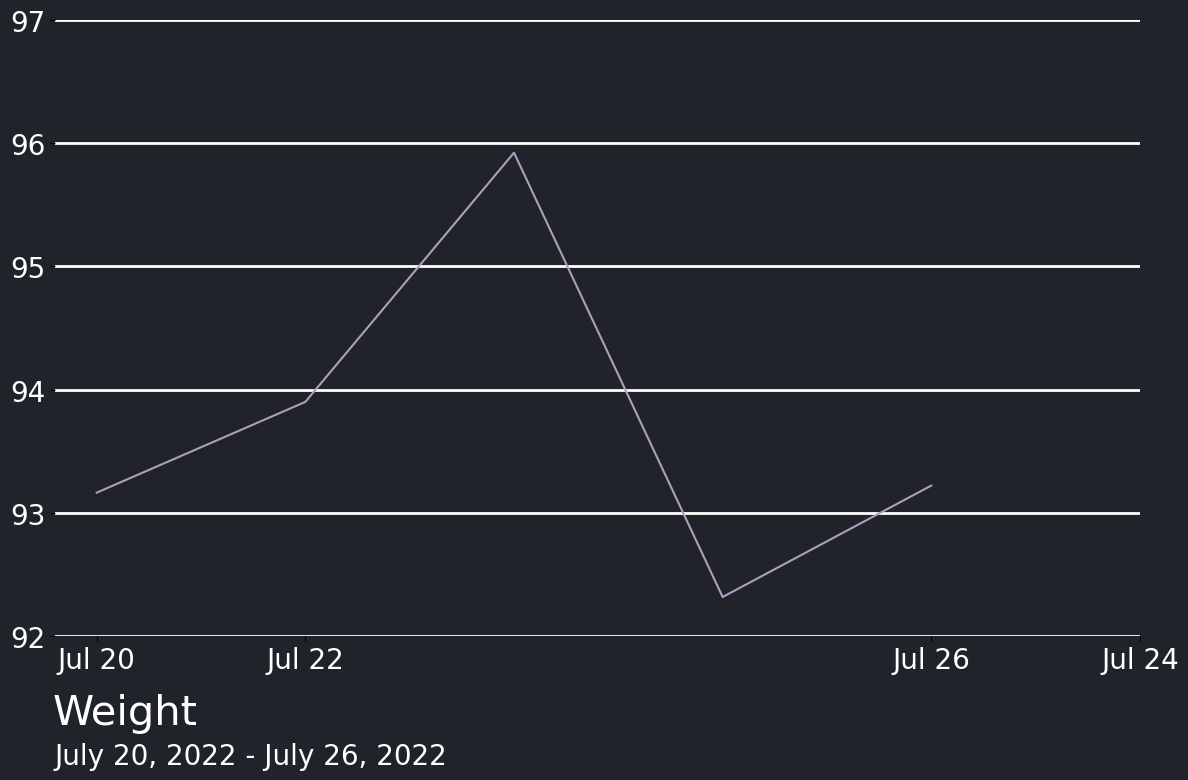

In [37]:
#@title Set date range for the chart above

start = "2022-07-20" #@param {type:"date"}
end = "2022-07-26" #@param {type:"date"}

# Creating a datetime object for the start date
start_date = datetime.strptime(start,'%Y-%m-%d')
start_date_string =(str(start_date.strftime("%B"))+' '+
                    str(start_date.day)+', '+str(start_date.year))

# Creating a datetime object for our end date
end_date = datetime.strptime(end,'%Y-%m-%d')
end_date_string =(str(end_date.strftime("%B"))+' '+
                    str(end_date.day)+', '+str(end_date.year))

# Finding a list of all dates between start and end date
dates = list(pd.date_range(start_date,end_date,freq='d'))
dates = [datetime.strftime(d,'%Y-%m-%d') for d in dates]

def date_fixer(date):
  # Creating a date time object for the date
  date = datetime.strptime(date,'%Y-%m-%d')
  # Returning the date in the required format
  return str(date.strftime("%B"))[:3]+' '+str(date.day)

# Getting only the weights values
weights = biometrics_df[biometrics_df.get('Metric')=='Weight']

datefixer = lambda x: datetime.strptime(x,'%Y-%m-%d')

weights = weights.assign(Day=weights.get('Day').apply(datefixer))

# Assigning the date_fixer function for getting the required xticks
xticks_fixed = [date_fixer(d) for d in dates]

weights = weights[weights.get('Day')>=start_date]
weights = weights[weights.get('Day')<=end_date]

weights =  weights.assign(Day=weights.get('Day').apply(lambda x: str(x)[:10]))

# Initializing the figure
fig1 = plt.figure(figsize=(14,8),facecolor='#20242A')
ax = fig1.gca()
ax.set_facecolor('#20242A')

# Plotting the Data
plt.plot(weights.get('Day'),weights.get('Amount'),color='#AE9EBD')

# Adding grids
plt.grid(axis="y",lw=2,color='white')
plt.grid(axis='x', alpha=0)

# Setting x and y ticks
plt.yticks(range(int(np.floor(np.min(list(weights.get('Amount'))))),
         int(np.ceil(np.max(list(weights.get('Amount')))+2))),color='white',
         fontsize = 20)
plt.xticks(dates[::2],xticks_fixed[::2],color='white', fontsize = 20, )

# Setting y limits for the graph
plt.ylim(np.floor(np.min(list(weights.get('Amount')))),
         np.ceil(np.max(list(weights.get('Amount')))+1))


# Removing the spines on top, left and right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Adding the weight footer
plt.text(0.175,0,'Weight',transform=fig1.transFigure, color='white',
         horizontalalignment='center',fontsize=30,
         family='sans-serif')
plt.text(0.265,-0.05, start_date_string+" - "+end_date_string, 
         transform=fig1.transFigure, color='white',horizontalalignment='center'
         ,fontsize=20, fontweight=550, family='sans-serif')
# Displaying the graph
plt.show()

*^ Above is a plot we created ourselves!*

## 7.3 Plotting participants Workout Minutes

If the participant wears an Apple Watch or uses another compatible device, they can go onto the Fitness App to find their average workout minutes in a chart like the one below.

<img src="https://i.imgur.com/fmwCGoj.jpg">

*Above is a plot from the mobile app itself!*

As cronometer automatically syncs with Apple Health, we have access to all this workout data. In this part of the notebook we will be recreating the plot above.

Font files already exist, skipping download.


/var/folders/4q/pymtr0qd38d5nlrw_myxq5r00000gn/T/ipykernel_75176/2362222970.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  exercises_grouped = exercises_df[exercises_df.get('Exercise')!="Active Energy Balance (Apple Health)"].groupby('Day').sum()


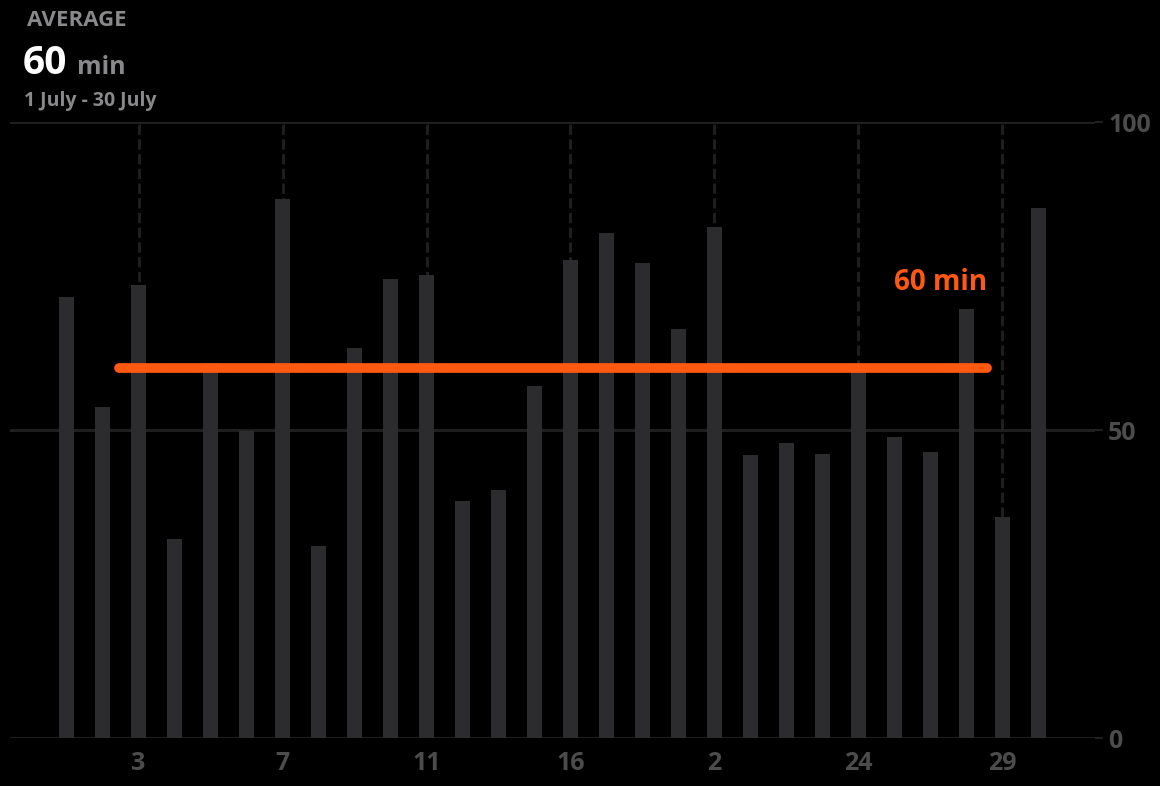

In [55]:
#@title Set date range for the chart above

start_date = "2022-07-01" #@param {type:"date"}
end_date = "2022-07-30" #@param {type:"date"}

# The next line creates the date header for the chart
date_range_text= (str(datetime.strptime(start_date,'%Y-%m-%d').day)+
                  ' '+datetime.strptime(start_date,'%Y-%m-%d').strftime("%B")+
                  ' - '+str(datetime.strptime(end_date,'%Y-%m-%d').day)+' '+
                  datetime.strptime(end_date,'%Y-%m-%d').strftime("%B"))

def date_fixer(date):
  # Creating a date time object for the date
  date = datetime.strptime(date,'%Y-%m-%d')
  # Returning the date in the required format
  return str(date.strftime("%B"))[:3]+' '+str(date.day)

exercises_df = pd.DataFrame.from_dict(exercises)
exercises_grouped = exercises_df[exercises_df.get('Exercise')!="Active Energy Balance (Apple Health)"].groupby('Day').sum()

start_date = datetime.strptime(start_date,'%Y-%m-%d')
end_date = datetime.strptime(end_date,'%Y-%m-%d')

dates = list(pd.date_range(start_date,end_date,freq='d'))
dates = [datetime.strftime(d,'%Y-%m-%d') for d in dates]
exercises_grouped = exercises_grouped.reset_index()
exercises_grouped = exercises_grouped.assign(Day_cleaned=exercises_grouped.get('Day').apply(datefixer))

# Assigning the date_fixer function for getting the required xticks
xticks_fixed = [date_fixer(d) for d in dates]


exercises_grouped = exercises_grouped[exercises_grouped.get('Day_cleaned')>=start_date]
exercises_grouped = exercises_grouped[exercises_grouped.get('Day_cleaned')<=end_date]

exercises_grouped = exercises_grouped.set_index('Day')

font_files = [
    "OpenSans-Regular.ttf",
    "OpenSans-Light.ttf",
    "OpenSans-Semibold.ttf",
    "OpenSans-Bold.ttf",
    "OpenSans-ExtraBold.ttf"
]

font_directory = "Fonts/"
font_url = "https://www.fontsquirrel.com/fonts/download/open-sans"

# Check if the font files already exist
missing_fonts = [font_file for font_file in font_files if not os.path.exists(os.path.join(font_directory, font_file))]

if missing_fonts:
    print("Downloading font files...")
    !wget {font_url}
    !unzip -o open-sans.zip
    
    # Move the font files only if they are missing
    for font_file in font_files:
        font_path = 'Fonts/'+font_file
        if os.path.exists(font_path):
            !mv -f {font_path} {font_directory}
else:
    print("Font files already exist, skipping download.")


# Initializing the figure
plt2 = plt.figure(figsize=(14,8),facecolor='#000000')
ax = plt2.gca()
ax.set_facecolor('#000000')
ax.yaxis.tick_right()
ax.set_axisbelow(True)

# Remove the outline and set background color
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_facecolor('none')  # Set the axes background color

# Chart mean
chart_mean = int(exercises_grouped.get('Minutes').mean())

# Creating grid lines
plt.grid(axis = 'x',color="#a1a1a1", linestyle='--', linewidth=2, alpha = 0.2)
plt.grid(axis = 'y',color="#a1a1a1", linestyle='-', linewidth=2, alpha = 0.2)

# Plotting the chart
plt.bar(exercises_grouped.index, exercises_grouped.get('Minutes'), width=0.4, 
        color='#2C2C2E', joinstyle='round', edgecolor="none")

plt.axhline(y=int(exercises_grouped.get('Minutes').mean()), xmin=0.1, 
            linewidth=7,xmax= 0.9, color='#FF5810',solid_capstyle='round')

# Adding Heart header

openSansBold = 'Fonts/OpenSans-Bold.ttf'
opensans_bold = fm.FontProperties(fname=openSansBold, size= 18, weight='bold')
opensans_bold_heading = fm.FontProperties(fname=openSansBold, size= 36, weight='bold')


openSansExtraBold = 'Fonts/OpenSans-ExtraBold.ttf'
opensans_ebold = fm.FontProperties(fname=openSansExtraBold, size= 16, weight=500)

find_tens = lambda start, end: [i for i in range(int(start), int(end)+1) if i % 50 == 0]
# Setting x and y ticks
yticks = find_tens(0,max(exercises_grouped.get('Minutes')+50))
plt.yticks(yticks, color='white',fontsize=16, fontweight=600,
           alpha=0.3, fontproperties=opensans_bold)
plt.xticks(exercises_grouped.index[2::4],
           [d.split('-')[2].strip('0') for d in list(exercises_grouped.index)][2::4],
           color='white',fontsize=16, fontweight=600,
           alpha=0.3, fontproperties=opensans_bold)
plt.text(0.79,chart_mean/yticks[-1]+0.07,str(chart_mean)+' min',
         fontsize=20,transform=plt2.transFigure, 
         horizontalalignment='center', color = '#FF5810', fontproperties=opensans_bold)


plt.text(0.173,1,"AVERAGE",fontsize=16,color='#89898B',transform=plt2.transFigure,
         horizontalalignment='center', fontproperties=opensans_bold)
plt.text(0.15,0.94,str(chart_mean),
         fontsize=28,transform=plt2.transFigure, 
         horizontalalignment='center', color = 'white',
         fontproperties=opensans_bold_heading)
plt.text(0.19,0.94,'min',fontsize=18,transform=plt2.transFigure, 
         horizontalalignment='center',color='#89898B',fontproperties=opensans_bold)
plt.text(0.182,0.9,date_range_text,fontsize=14,color='#89898B',
         transform=plt2.transFigure, horizontalalignment='center',
         fontproperties=opensans_bold)

# Plotting the chart
plt.show()


*^ Above is a plot we created ourselves!*


# 8. Data Analysis

While doing some research for increasing muscle mass, I stumbled upon an [article](https://www.healthyeating.org/nutrition-topics/general/food-groups/protein) on this website called [HealthyEating](https://www.healthyeating.org) by the [Dairy Council of California](https://en.wikipedia.org/wiki/Dairy_Council_of_California). This article started with a claim that high-protein foods like meat, poultry, fish, beans and peas, eggs and nuts and seeds were also an excellent source of B vitamins. <br> <br>

In this portion of the notebook, we will see if there is a general correlation between a food's protein makeup and these given nutrients. <br><br>
Before beginning this experiment, let's replot our servings dataset which contains all the food items logged into the Cronometer app.

In [42]:
servings_df.head()

,Day,Food Name,Amount,Energy (kcal),Alcohol (g),Caffeine (mg),Water (g),B1 (Thiamine) (mg),B2 (Riboflavin) (mg),B3 (Niacin) (mg),...,Leucine (g),Lysine (g),Methionine (g),Phenylalanine (g),Protein (g),Threonine (g),Tryptophan (g),Tyrosine (g),Valine (g),Category
0,2022-03-01,"Chipotle, Black Beans","1.00 cup, whole pieces",196.16,0.0,0.0,122.04,0.34,0.09,0.79,...,0.94,0.81,0.18,0.64,11.95,0.50,0.14,0.34,0.62,Fast Foods
1,2022-03-02,"Yam, Cooked, Boiled, Drained, or Baked, with Salt",300.00 g,342.00,NaN,NaN,210.39,0.28,0.08,1.66,...,0.28,0.17,0.06,0.21,4.47,0.16,0.04,0.12,0.18,Vegetables and Vegetable Products
2,2022-03-04,"Sausage, Pork, Fresh",3.00 medium link - breakfast size,195.00,0.0,0.0,29.93,0.15,0.11,3.67,...,0.82,0.74,0.26,0.40,11.12,0.37,0.11,0.31,0.53,Sausages and Luncheon Meats
3,2022-03-05,"Whole Wheat Bread, Store Bought",2.00 medium slice,181.44,0.0,0.0,28.09,0.28,0.12,3.20,...,0.29,0.12,0.07,0.20,8.96,0.12,0.07,0.13,0.20,Baked Products
4,2022-03-06,"Banquet, Spaghetti & Meatballs",1.00 package - each 10 oz,323.84,0.0,0.0,223.32,0.41,0.30,4.14,...,1.22,0.98,0.32,0.72,15.94,0.62,0.18,0.52,0.77,"Meals, Entrees, and Sidedishes"


This current Data Frame has 55 columns, let's shorted it down to the columns that we specifically require in our analysis.

In [43]:
servings_cleaned = servings_df.get(['Day','Protein (g)','B1 (Thiamine) (mg)',
       'B2 (Riboflavin) (mg)', 'B3 (Niacin) (mg)',
       'B5 (Pantothenic Acid) (mg)', 'B6 (Pyridoxine) (mg)',
       'B12 (Cobalamin) (µg)']).dropna()

servings_cleaned.head()

,Day,Protein (g),B1 (Thiamine) (mg),B2 (Riboflavin) (mg),B3 (Niacin) (mg),B5 (Pantothenic Acid) (mg),B6 (Pyridoxine) (mg),B12 (Cobalamin) (µg)
0,2022-03-01,11.95,0.34,0.09,0.79,0.36,0.14,0.00
2,2022-03-04,11.12,0.15,0.11,3.67,0.48,0.12,0.59
3,2022-03-05,8.96,0.28,0.12,3.20,0.47,0.15,0.00
4,2022-03-06,15.94,0.41,0.30,4.14,0.57,0.27,0.62
5,2022-03-07,12.78,0.49,0.52,3.35,0.88,0.21,0.74


As we there are multiple versions of Vitamin Bs, let's aggregate them into a single column with the sum of all Vitamin Bs.

In [44]:
servings_cleaned = servings_cleaned.assign(Vitamin_B = servings_cleaned.get([
    'B1 (Thiamine) (mg)','B2 (Riboflavin) (mg)', 'B3 (Niacin) (mg)',
    'B5 (Pantothenic Acid) (mg)', 'B6 (Pyridoxine) (mg)',
    'B12 (Cobalamin) (µg)']).sum(axis=1))

servings_cleaned.head()

,Day,Protein (g),B1 (Thiamine) (mg),B2 (Riboflavin) (mg),B3 (Niacin) (mg),B5 (Pantothenic Acid) (mg),B6 (Pyridoxine) (mg),B12 (Cobalamin) (µg),Vitamin_B
0,2022-03-01,11.95,0.34,0.09,0.79,0.36,0.14,0.00,1.72
2,2022-03-04,11.12,0.15,0.11,3.67,0.48,0.12,0.59,5.12
3,2022-03-05,8.96,0.28,0.12,3.20,0.47,0.15,0.00,4.22
4,2022-03-06,15.94,0.41,0.30,4.14,0.57,0.27,0.62,6.31
5,2022-03-07,12.78,0.49,0.52,3.35,0.88,0.21,0.74,6.19


For our plot, let's see if there is a visual correlation between the Protein content of a food item and their Vitamin B content. 

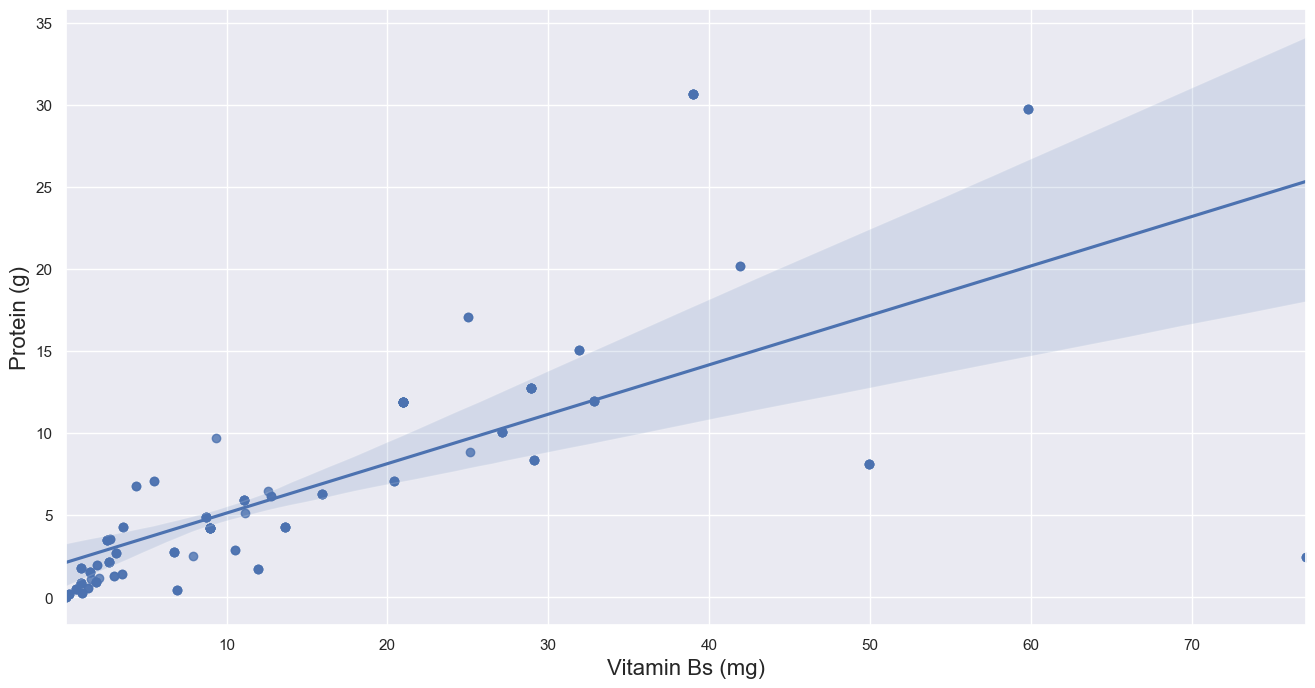

In [45]:
# Setting Figure Size in Seaborn
sns.set(rc={'figure.figsize':(16,8)})

# Setting Seaborn plot style
sns.set_style("darkgrid")

#Plotting our data
plot = sns.regplot(data=servings_cleaned, x='Protein (g)', y="Vitamin_B")

#Renaming x and y labels
plot.set_ylabel("Protein (g)", fontsize = 16)
plot.set_xlabel("Vitamin Bs (mg)", fontsize = 16)

print()

Based on the graph, it appears that there is a positive association between the protein content and vitamin B content in food. To confirm this relationship statistically, we will utilize linear regression to determine the optimal line of fit and calculate the correlation coefficient and p-value.

To perform the linear regression and obtain the correlation coefficient and p-value, you can use statistical functions from the scipy package in Python. The scipy.stats module provides functions for linear regression, correlation coefficient calculation, and p-value calculation.

In [46]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    servings_cleaned.get('Protein (g)'), servings_cleaned.get('Vitamin_B'))

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: 0.301
Coefficient of determination: 0.473
p-value: 6.92e-25


The p-value is 6.92e-25 is much smaller than the 5% cutoff. This means that there is enough evidence to convincingly conclude that that there is a correlation between protein and vitamin B intake in a food item.

## 9.0 Outlier Detection

However, even though our P value seems to provide enough statistical significance that there is a correlation between Protein and Vitamin B makeup, there might be outliers that are not following this correlation. In this section of our analysis, we will find if there are outliers like that and if they exist, we will visually highlight them in our plot.

Before finding the individual outlier values, it would be interesting to see the summary of our Protein and Vitamin B intake. Analyzing a summary of our Protein and Vitamin B intake would be valuable as it provides insight into the typical values and highlights values that may be considered unusual based on the data we collected from Cronometer. The summary shows key statistical measures such as the minimum, maximum, mean, median, and standard deviation of the data, which can give us an idea of the range and distribution of the values.

In [47]:
servings_cleaned_summary = servings_cleaned.describe().get(
                                          ['Protein (g)','Vitamin_B']).drop('count')
servings_cleaned_summary

,Protein (g),Vitamin_B
mean,15.377440,6.744464
std,16.499285,7.224528
min,0.010000,0.000000
25%,2.570000,1.772500
50%,8.960000,4.260000
75%,25.020000,10.050000
max,77.080000,30.640000


To locate the outliers we will be using a supervised as well as unsupervised algorithm called the Elliptic Envelope. In statistical studies, Elliptic Envelope created an imaginary elliptical area around a given dataset where values inside that imaginary area is considered to be normal data, and anything else is assumed to be outliers. It assumes that the given Data follows a gaussian distribution.

"The main idea is to define the shape of the data and anomalies are those observations that lie far outside the shape. First a robust estimate of covariance of data is fitted into an ellipse around the central mode. Then, the Mahalanobis distance that is obtained from this estimate is used to define the threshold for determining outliers or anomalies." [(S. Shriram and E. Sivasankar ,2019, pp. 221-225)](https://ieeexplore.ieee.org/document/9004325)

In [48]:
# Sometimes EllipticEnvelope shows slicing based copy warnings
# The next line changes a setting that prevents the error from happening

pd.set_option('mode.chained_assignment', None)

#create the model, set the contamination as 0.02
EE_model = EllipticEnvelope(contamination = 0.02)

#implement the model on the data
outliers = EE_model.fit_predict(servings_cleaned.get(
                                                  ['Protein (g)','Vitamin_B']))

#extract the labels
servings_cleaned["outlier"] = copy.deepcopy(outliers)

#change the labels
# We use -1 to mark an outlier and +1 for an inliner
servings_cleaned["outlier"] = servings_cleaned["outlier"].apply(
                                    lambda x: str(-1) if x == -1 else str(1))

#extract the score
servings_cleaned["EE_scores"] = EE_model.score_samples(
                      servings_cleaned.get(['Protein (g)','Vitamin_B']))

#print the value counts for inlier and outliers
print(servings_cleaned["outlier"].value_counts())

1     165
-1      3
Name: outlier, dtype: int64


Below we will replot the servings_cleaned_summary dataframe to see how the two new columns were applied to it!

In [49]:
servings_cleaned.head()

,Day,Protein (g),B1 (Thiamine) (mg),B2 (Riboflavin) (mg),B3 (Niacin) (mg),B5 (Pantothenic Acid) (mg),B6 (Pyridoxine) (mg),B12 (Cobalamin) (µg),Vitamin_B,outlier,EE_scores
0,2022-03-01,11.95,0.34,0.09,0.79,0.36,0.14,0.00,1.72,1,-9.437857
2,2022-03-04,11.12,0.15,0.11,3.67,0.48,0.12,0.59,5.12,1,-0.438159
3,2022-03-05,8.96,0.28,0.12,3.20,0.47,0.15,0.00,4.22,1,-0.131907
4,2022-03-06,15.94,0.41,0.30,4.14,0.57,0.27,0.62,6.31,1,-2.704533
5,2022-03-07,12.78,0.49,0.52,3.35,0.88,0.21,0.74,6.19,1,-0.715227



Now that we have labeled the outliers as -1, let's try to see which values of protien intake and vitamin B are being identified as outliers by our Elliptic Envelope Algorithm.

In [50]:
outlier_df = servings_cleaned[servings_cleaned.get('outlier')=='-1'].get(
    ['Protein (g)','Vitamin_B'])
outlier_df_cleaned = outlier_df.drop_duplicates()
outlier_df_cleaned

,Protein (g),Vitamin_B
60,77.08,2.45


By matching the outlier values with their respective food items, we can identify which specific foods are contributing to the outliers in our protein vs. vitamin scatterplot. This information can help us understand which foods may be driving the unusual values and potentially provide insights into why these outliers exist.

In [51]:
servings_df.loc[outlier_df_cleaned.index]['Food Name'].to_list()

['Whey Protein Powder, 24 Grams of Protein per Scoop']

Our algorithm identifies the scoop of protein powder as an outlier due to its high protein content relative to its low Vitamin B content, which causes it to deviate significantly from the overall pattern of the data in the protein vs. Vitamin B scatterplot.

Sweet, now that we know that there were outliers in our dataset, let's try to visually see which pair of values are being identified as outliers using a plot. Highlighting these outliers in a bright red color will make it super easy for us to identify them in our plot.

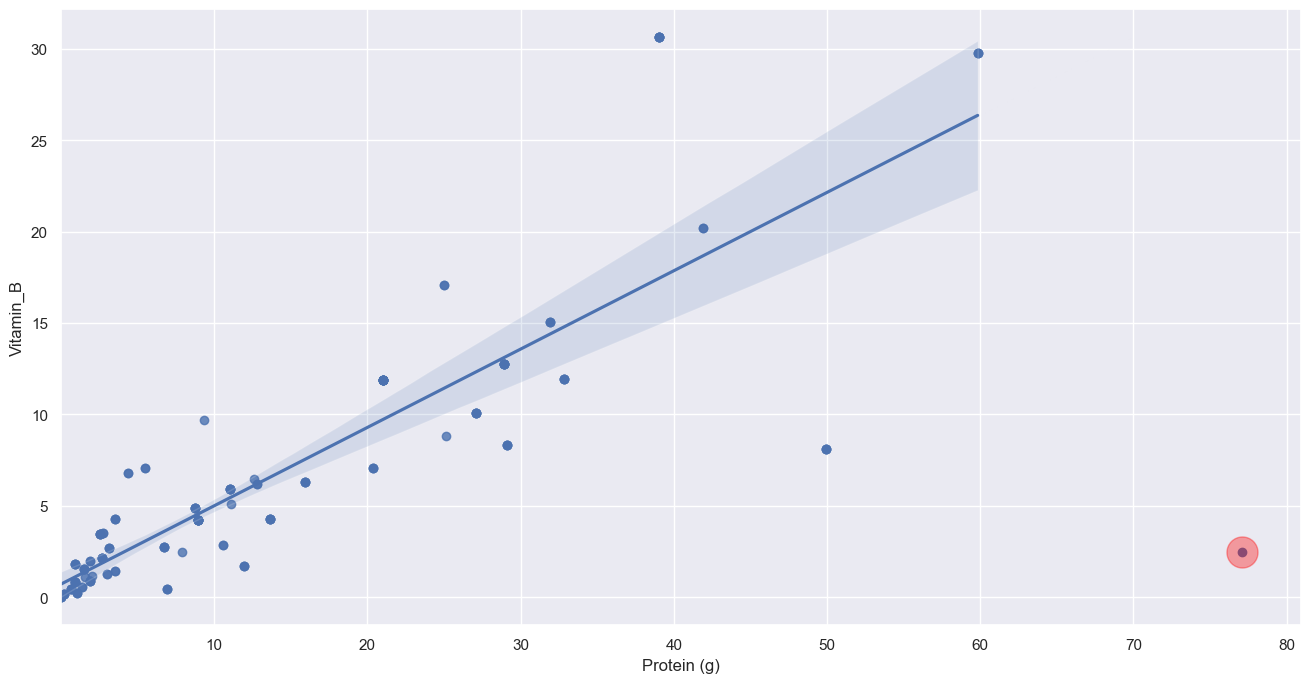

In [52]:
# Setting Figure Size in Seaborn
sns.set(rc={'figure.figsize':(16,8)})

# Setting Seaborn plot style
sns.set_style("darkgrid")

#Plotting our data
plot = sns.regplot(x='Protein (g)', y='Vitamin_B', data=servings_cleaned.drop(
    outlier_df.index))

plt.scatter(outlier_df_cleaned.get('Protein (g)'),outlier_df_cleaned.get('Vitamin_B'))
plt.scatter(outlier_df_cleaned.get('Protein (g)'),outlier_df_cleaned.get('Vitamin_B'),
            facecolors='red',alpha=.35, s=500)

plt.show()

Thus, the points highlighted in red are ones that seem to not be following the general trend of our dataset. Lastly, let's see what the new p-value is after outlier removal!

In [53]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    servings_cleaned.drop(outlier_df.index).get('Protein (g)'),
     servings_cleaned.drop(outlier_df.index).get('Vitamin_B'))

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: 0.429
Coefficient of determination: 0.718
p-value: 1.14e-46


Our new p-value after removing any outliers is 1.14e-46 which is still less than 5% and smaller than our p-value with the outliers included in the dataset. Therefore, after removing the outliers, our result is statistically significant which means that there is enough evidence to conclude that that there is a correlation between Protein content and Vitamin B content in a food item.